In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns
import threading
import os
import matplotlib.mlab as ml
import h5py

from scipy import optimize
import sys
sys.path.insert(0, '/Users/yihanwang/Projects/athena/vis/python')
import athena_read as ar
plt.rcParams['agg.path.chunksize']=100000
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams["font.family"] = "Arial"
#plt.style.use('seaborn-deep')
plt.rc('grid', linestyle="--", color='gray')
#plt.rc('xtick', direction = 'in')
#plt.rc('ytick', direction= 'in')
# @working path
FIG_PATH     = '../tex/figs/'
WEB_FIG_PATH = '../tex/web-figs/'
DATA_PATH    = '../code/'

# @global settings
WEB_FIG_DPI  = 600
FIG_DPI      = 800
FIG_EXT      = '.pdf'
WEB_FIG_EXT  = '.png'

# @global functions
def savefig(handler,name, fig_ext = FIG_EXT, web_fig_ext = WEB_FIG_EXT):
    if name != '':
        handler.savefig(FIG_PATH + name + fig_ext, dpi = FIG_DPI,bbox_inches = 'tight', pad_inches = 0)
    #handler.savefig(WEB_FIG_PATH + name + web_fig_ext, dpi = WEB_FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
prefix = 'off-axis-tophat/'

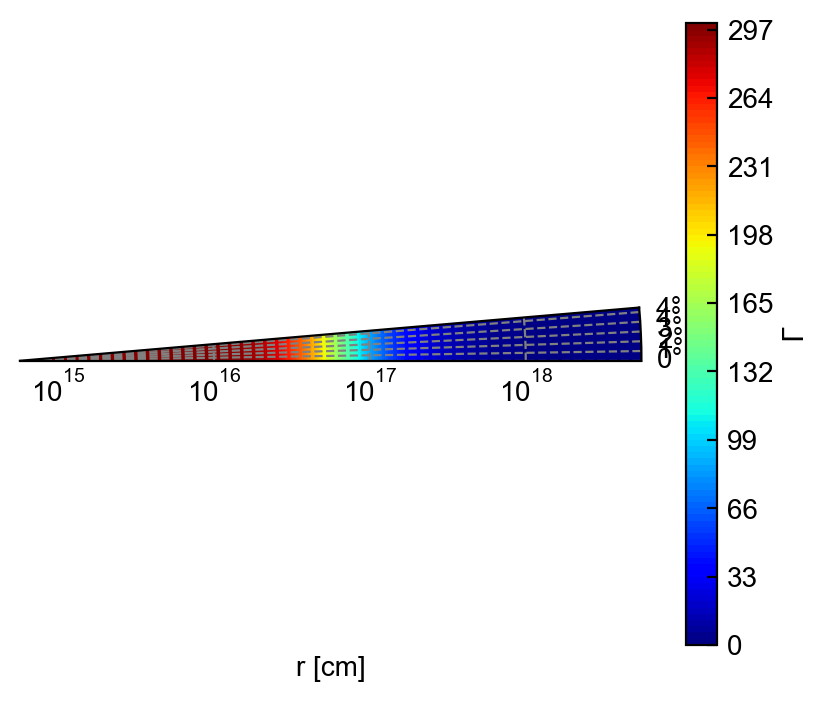

In [3]:
def show_dynamics(r_name, theta_name):
    r1d = np.loadtxt(r_name) * 1.5e13
    theta1d = np.loadtxt(theta_name)

    r, theta = np.meshgrid(r1d, theta1d)
    
    gamma = np.loadtxt(prefix+'Gamma.txt')

    fig = plt.figure(figsize=(4.8, 3.6))

    ax1 = fig.add_subplot(1,1,1,projection='polar')
    cs = ax1.contourf(theta, r, (gamma), levels=100, cmap = 'jet')
    ax1.set_xlim(0, theta1d[-1])
    ax1.set_xlabel('r [cm]')
    cbar =plt.colorbar(cs)
    cbar.set_label(r'$\Gamma$')
    ax1.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(prefix+'gamma.png', dpi=300, bbox_inches='tight')

show_dynamics(prefix+'r.txt', prefix+'theta.txt')

[1. 2. 3.]


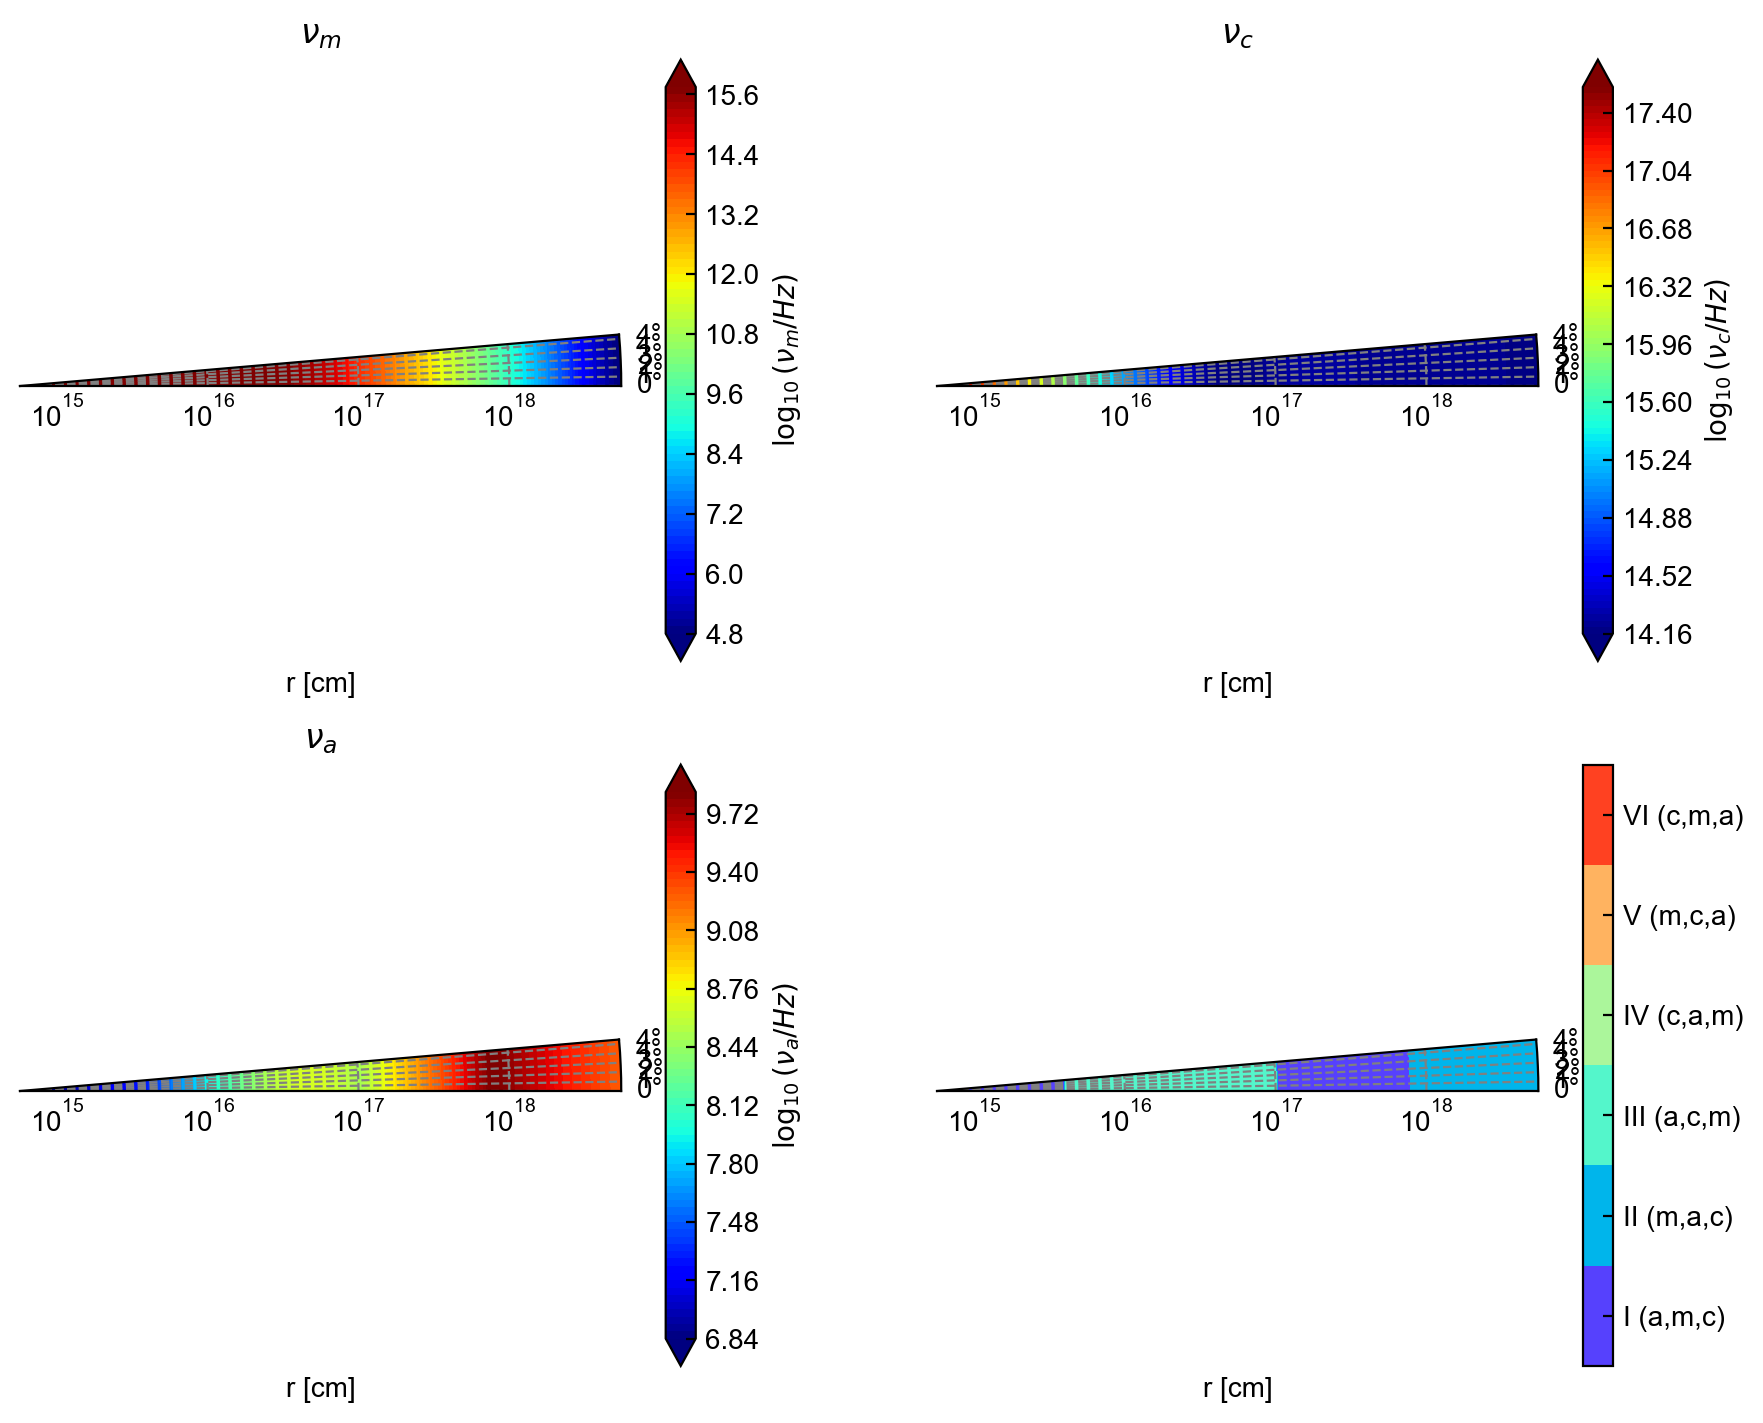

In [4]:
def show_syn_nv(r_name, theta_name):
    r1d = np.loadtxt(r_name) * 1.5e13
    theta1d = np.loadtxt(theta_name)

    r, theta = np.meshgrid(r1d, theta1d)
    
    nu_m = np.loadtxt(prefix+'syn_nu_m.txt')/500
    nu_c = np.loadtxt(prefix+'syn_nu_c.txt')/500
    nu_a = np.loadtxt(prefix+'syn_nu_a.txt')/500
    fig = plt.figure(figsize=(2*4.8, 2*3.6))

    min_nu = min(nu_m.min(),nu_c.min(),nu_a.min())
    max_nu = max(nu_m.max(),nu_c.max(),nu_a.max())

    axs = [ fig.add_subplot(2,2,i+1,projection='polar') for i in range(4)]
    for ax, nu, name in zip(axs, [nu_m, nu_c, nu_a], ['\\nu_m', '\\nu_c', '\\nu_a']):
        lv = np.linspace(np.log10(min_nu),np.log10(max_nu),100)
        cs = ax.contourf(theta, r, np.log10(nu), levels=100, cmap = 'jet',extend='both')
        ax.set_xlim(0, theta1d[-1])
        ax.set_xlabel('r [cm]')
        cbar =plt.colorbar(cs)
        cbar.set_label(r'$\log_{10}('+name+'/Hz)$')
        ax.set_yscale('log')
        ax.set_title('$'+name+'$')

    I = (nu_a < nu_m) & (nu_m < nu_c)
    II = (nu_m < nu_a) & (nu_a < nu_c)
    III = (nu_a < nu_c) & (nu_c < nu_m)
    IV = (nu_c < nu_a) & (nu_a < nu_m)
    V = (nu_m < nu_c) & (nu_c < nu_a)
    VI = (nu_c < nu_m) & (nu_m < nu_a)
    regime = np.zeros_like(nu_m)
    regime[I] = 1
    regime[II] = 2
    regime[III] = 3
    regime[IV] = 4
    regime[V] = 5
    regime[VI] = 6

    print(np.unique(regime))

    ax = axs[-1]
    
    cs = ax.contourf(theta, r, regime, levels=[0.5,1.5,2.5,3.5,4.5,5.5,6.5], cmap = 'rainbow')
    ax.set_xlim(0, theta1d[-1])
    ax.set_xlabel('r [cm]')
    cbar =plt.colorbar(cs, ticks=[1,2,3,4,5,6])
    cbar.ax.set_yticklabels(['I (a,m,c)', 'II (m,a,c)', 'III (a,c,m)','IV (c,a,m)','V (m,c,a)','VI (c,m,a)']) 
    ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig(prefix+'nu.png', dpi=300, bbox_inches='tight')

show_syn_nv(prefix+'r.txt', prefix+'theta.txt')

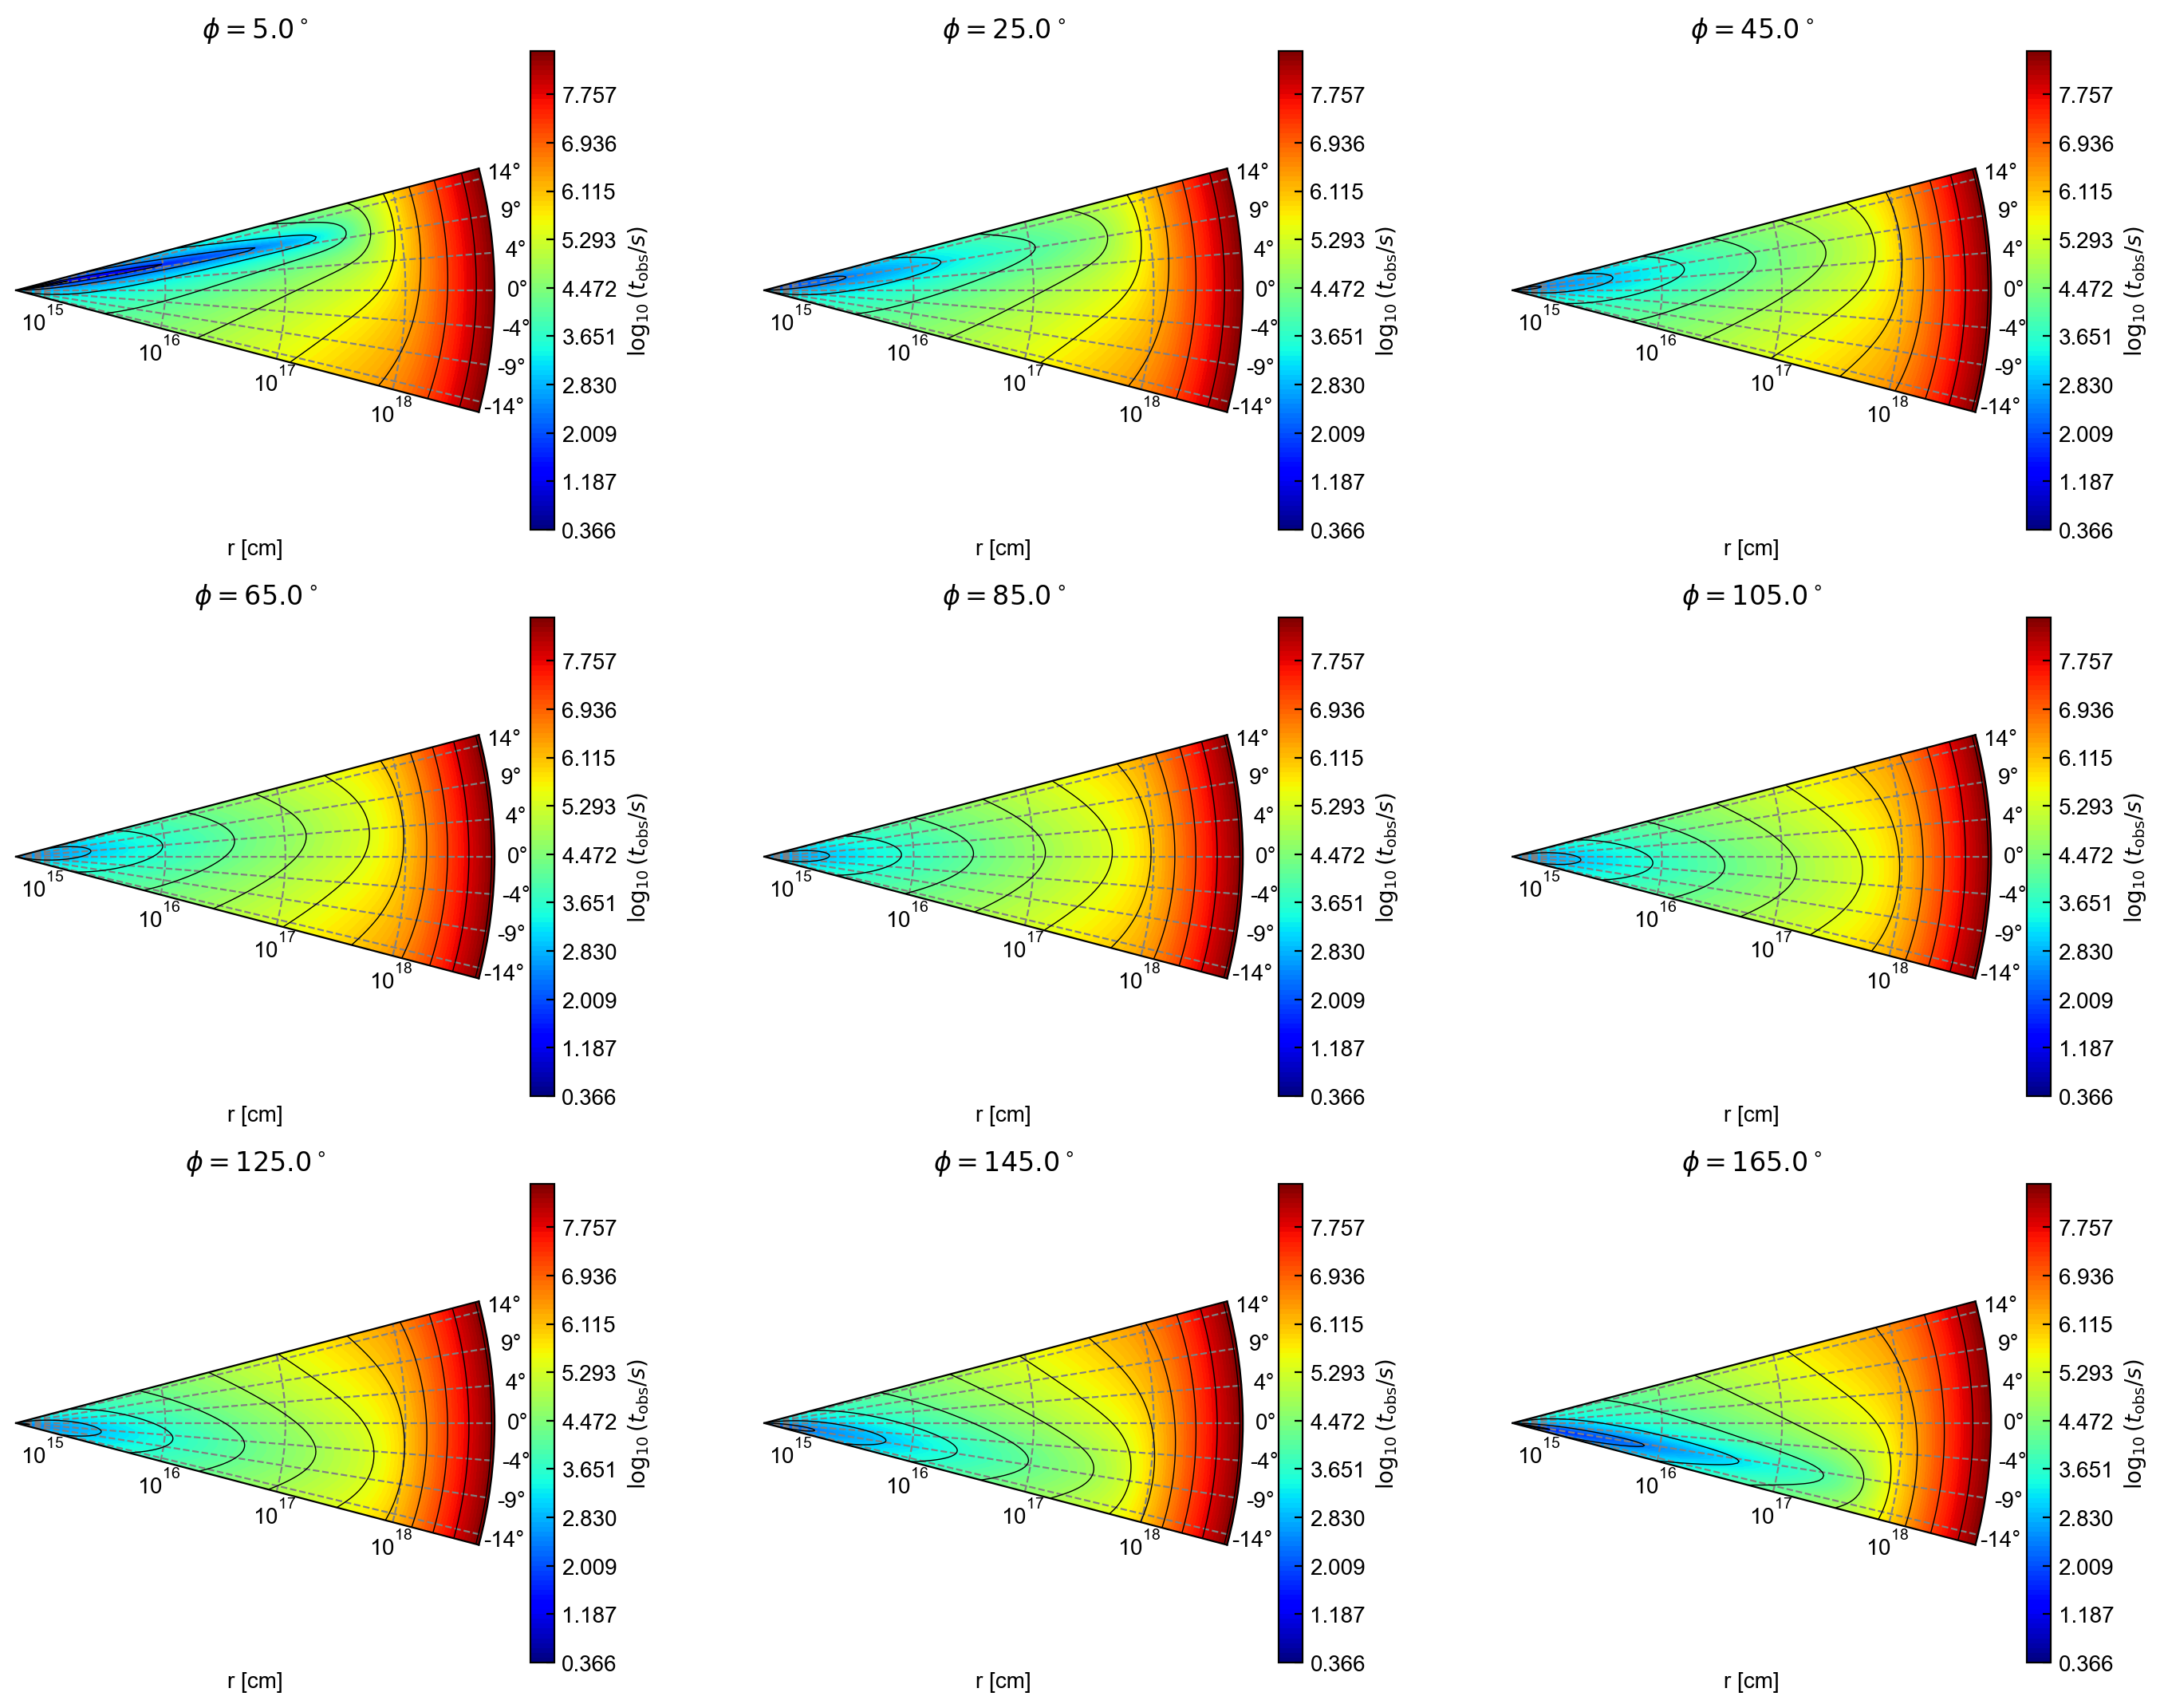

In [9]:
def draw_t_obs(r_name, theta_name, phi_name, var_name):
    r1d = np.loadtxt(r_name) * 1.5e13
    theta1d = np.loadtxt(theta_name)
    phi1d = np.loadtxt(phi_name)

    d = np.loadtxt(var_name)*500

    theta_ext = np.hstack([-theta1d[::-1], theta1d])

    fig = plt.figure(figsize=(4.8*3, 3.6*3))

    axs = [fig.add_subplot(3, 3, i+1,projection='polar') for i in range(int(len(phi1d)/4))]
    
    for i, ax in zip(range(int(len(phi1d)/4)), axs):
        i = i*2
        j = i + int(len(phi1d)/2)
        var1 = d[(j*len(theta1d)):(j+1)*len(theta1d),:]
        var2 = d[(i*len(theta1d)):(i+1)*len(theta1d),:]

        r, theta = np.meshgrid(r1d, theta_ext)

        var1 =np.flip(var1, axis=0)
        var = np.vstack([var1, var2])

        cs = ax.contourf(theta, r, np.log10(var), levels = np.linspace(np.log10(d[d>0]).min(),np.log10(d.max()),100), cmap = 'jet')
        cl=ax.contour(theta, r, np.log10(var), levels = 10, colors = 'black', linewidths = 0.5)

        ax.set_title('$\\phi = {:.1f}^\\circ$'.format(phi1d[i]/np.pi*180))
        ax.set_xlim(-theta1d[-1], theta1d[-1])
        ax.set_xlabel('r [cm]')
        cbar = plt.colorbar(cs)
        cbar.set_label('$\\log_{10}(t_{\\rm obs}/s)$')
        ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig(prefix+'t_obs.png', dpi=300, bbox_inches='tight')
    
draw_t_obs(prefix+'r.txt', prefix+'theta.txt', prefix+'phi.txt', prefix+'t_obs.txt')

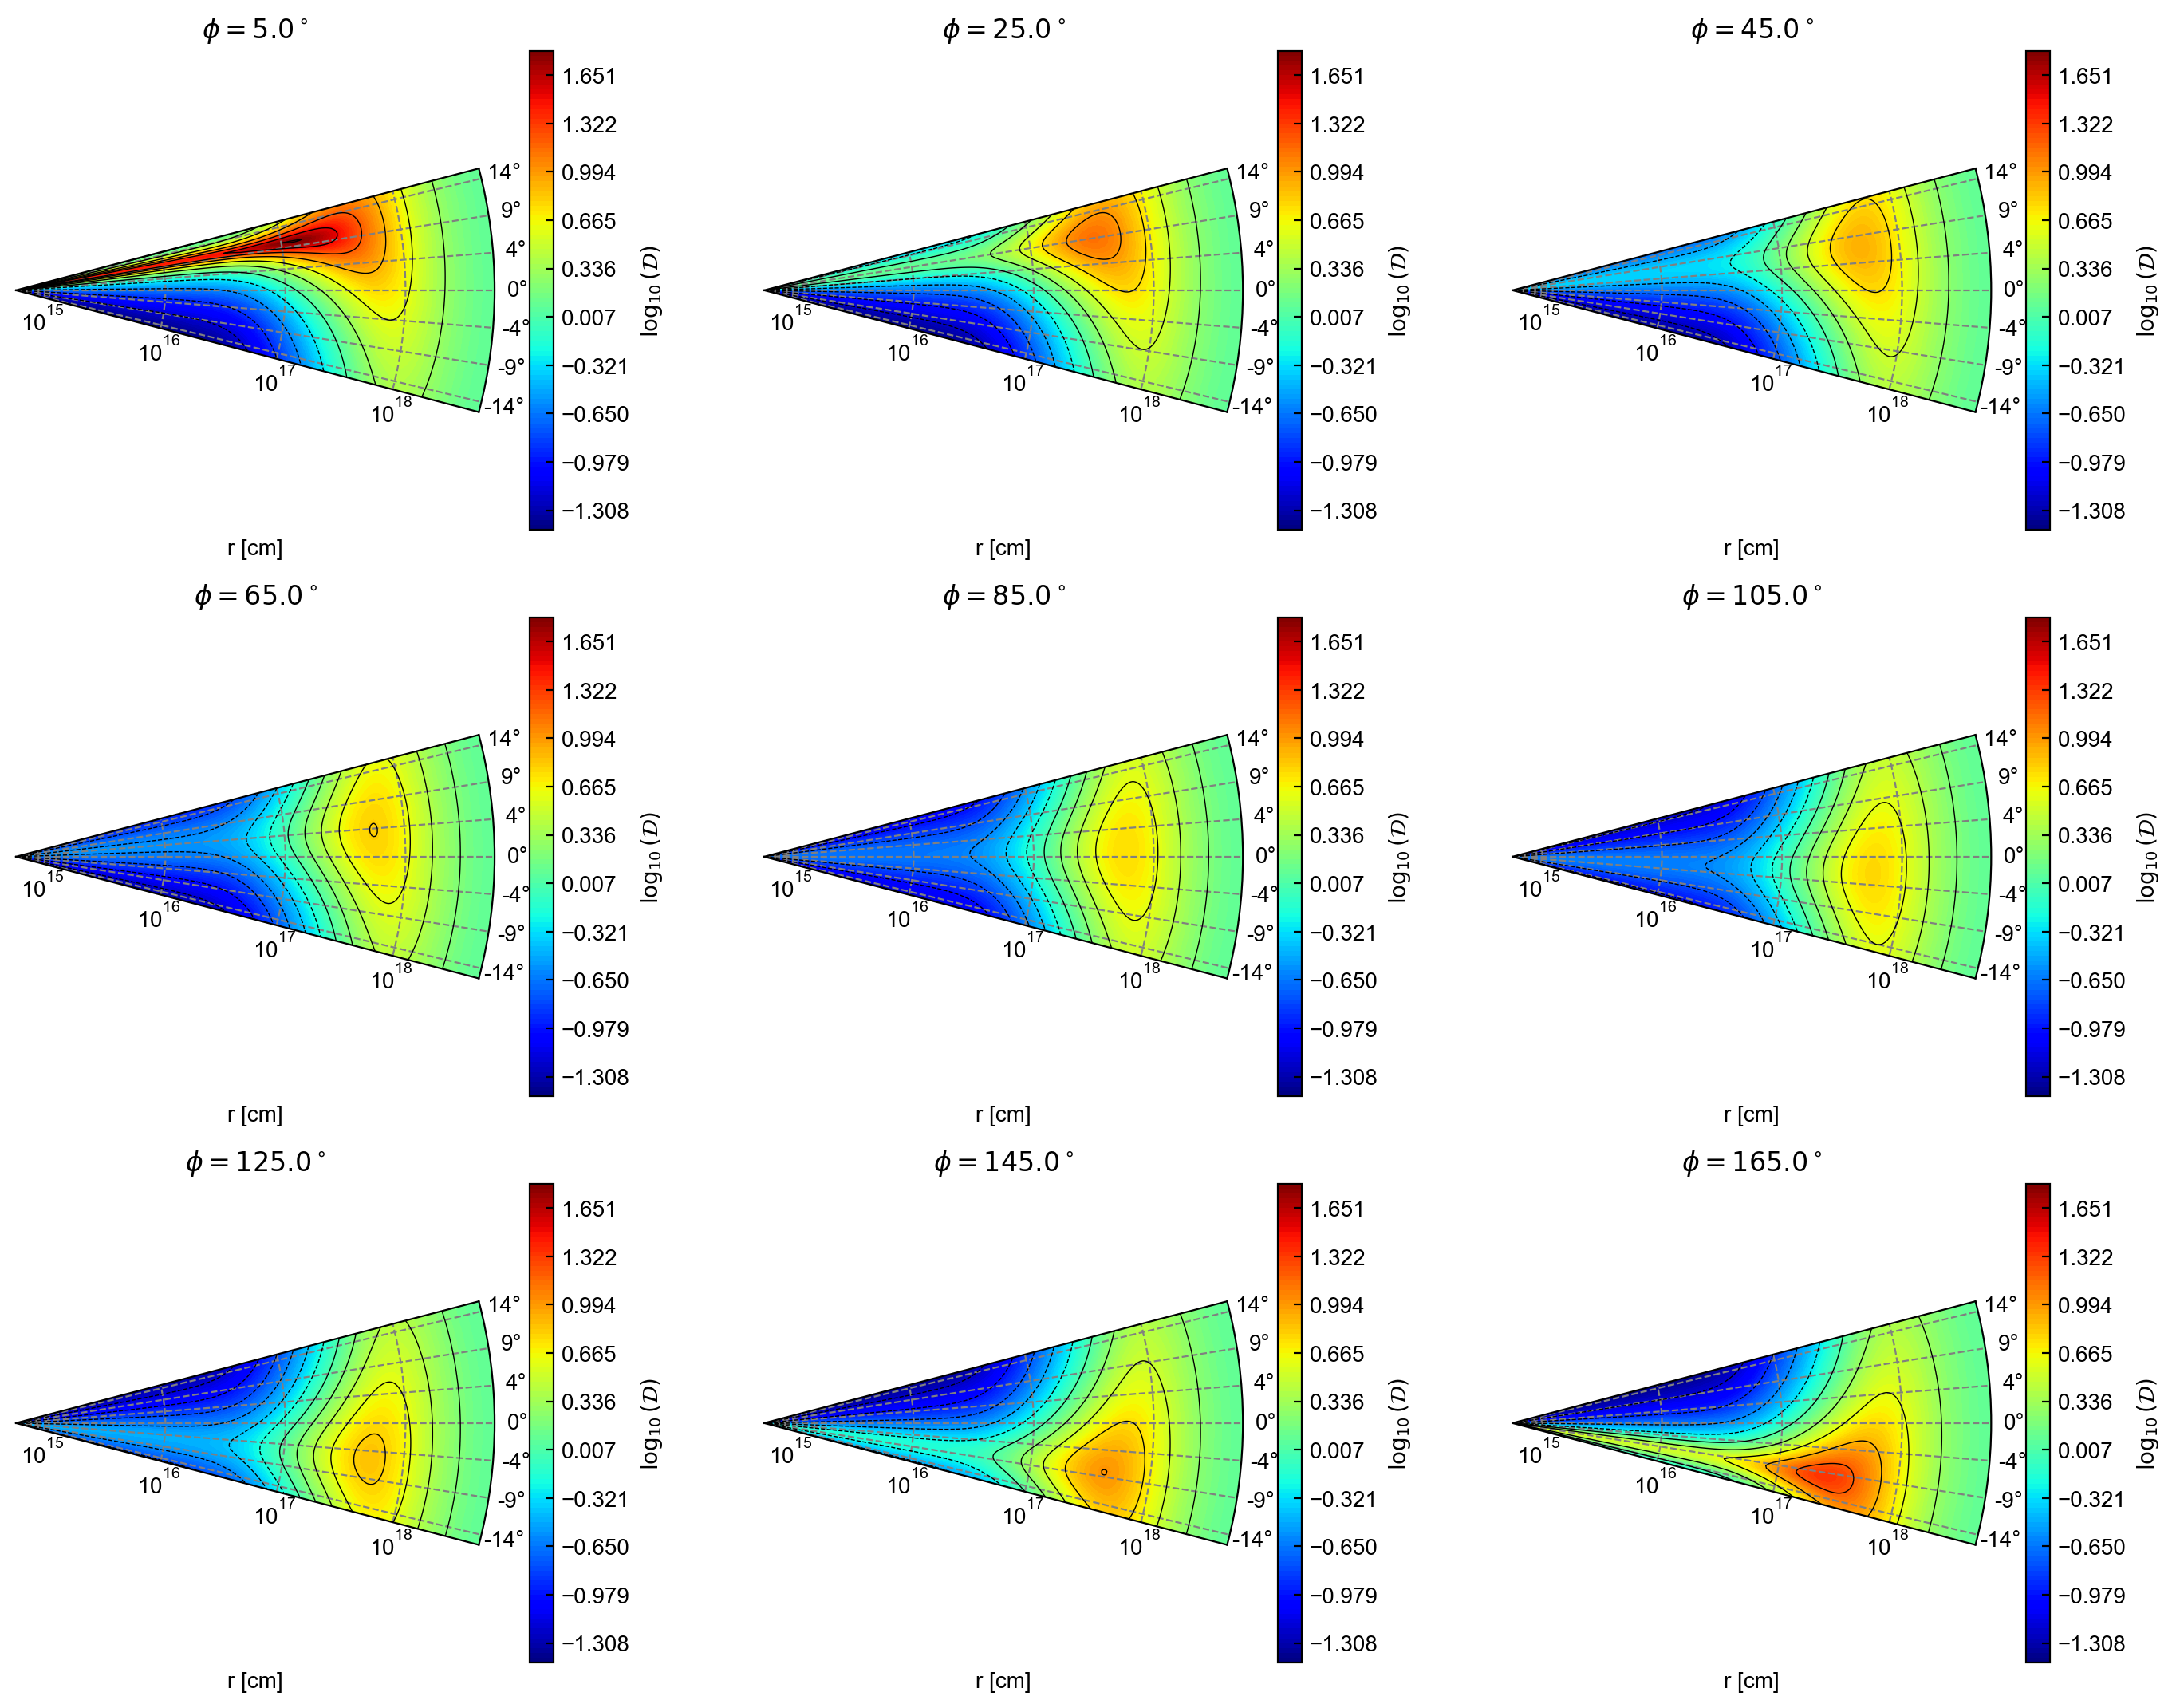

In [10]:
def draw_D(r_name, theta_name, phi_name, var_name):
    r1d = np.loadtxt(r_name) * 1.5e13
    theta1d = np.loadtxt(theta_name)
    phi1d = np.loadtxt(phi_name)

    d = np.loadtxt(var_name)

    theta_ext = np.hstack([-theta1d[::-1], theta1d])

    fig = plt.figure(figsize=(4.8*3, 3.6*3))

    axs = [fig.add_subplot(3, 3, i+1,projection='polar') for i in range(int(len(phi1d)/4))]
    
    for i, ax in zip(range(int(len(phi1d)/4)), axs):
        i = i*2
        j = i + int(len(phi1d)/2)

        var1 = d[(j*len(theta1d)):(j+1)*len(theta1d),:]
        var2 = d[(i*len(theta1d)):(i+1)*len(theta1d),:]

        r, theta = np.meshgrid(r1d, theta_ext)

        var1 =np.flip(var1, axis=0)
        var = np.vstack([var1, var2])

        cs = ax.contourf(theta, r, np.log10(var), levels = np.linspace(np.log10(d[d>0]).min(),np.log10(d.max()),100), cmap = 'jet')
        cl=ax.contour(theta, r, np.log10(var), levels = 10, colors = 'black', linewidths = 0.5)

        ax.set_title('$\\phi = {:.1f}^\\circ$'.format(phi1d[i]/np.pi*180))
        ax.set_xlim(-theta1d[-1], theta1d[-1])
        ax.set_xlabel('r [cm]')
        cbar = plt.colorbar(cs)
        cbar.set_label('$\\log_{10}(\\mathcal{D})$')
        ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig(prefix+'D.png', dpi=300, bbox_inches='tight')
    
draw_D(prefix+'r.txt', prefix+'theta.txt', prefix+'phi.txt', prefix+'doppler.txt')

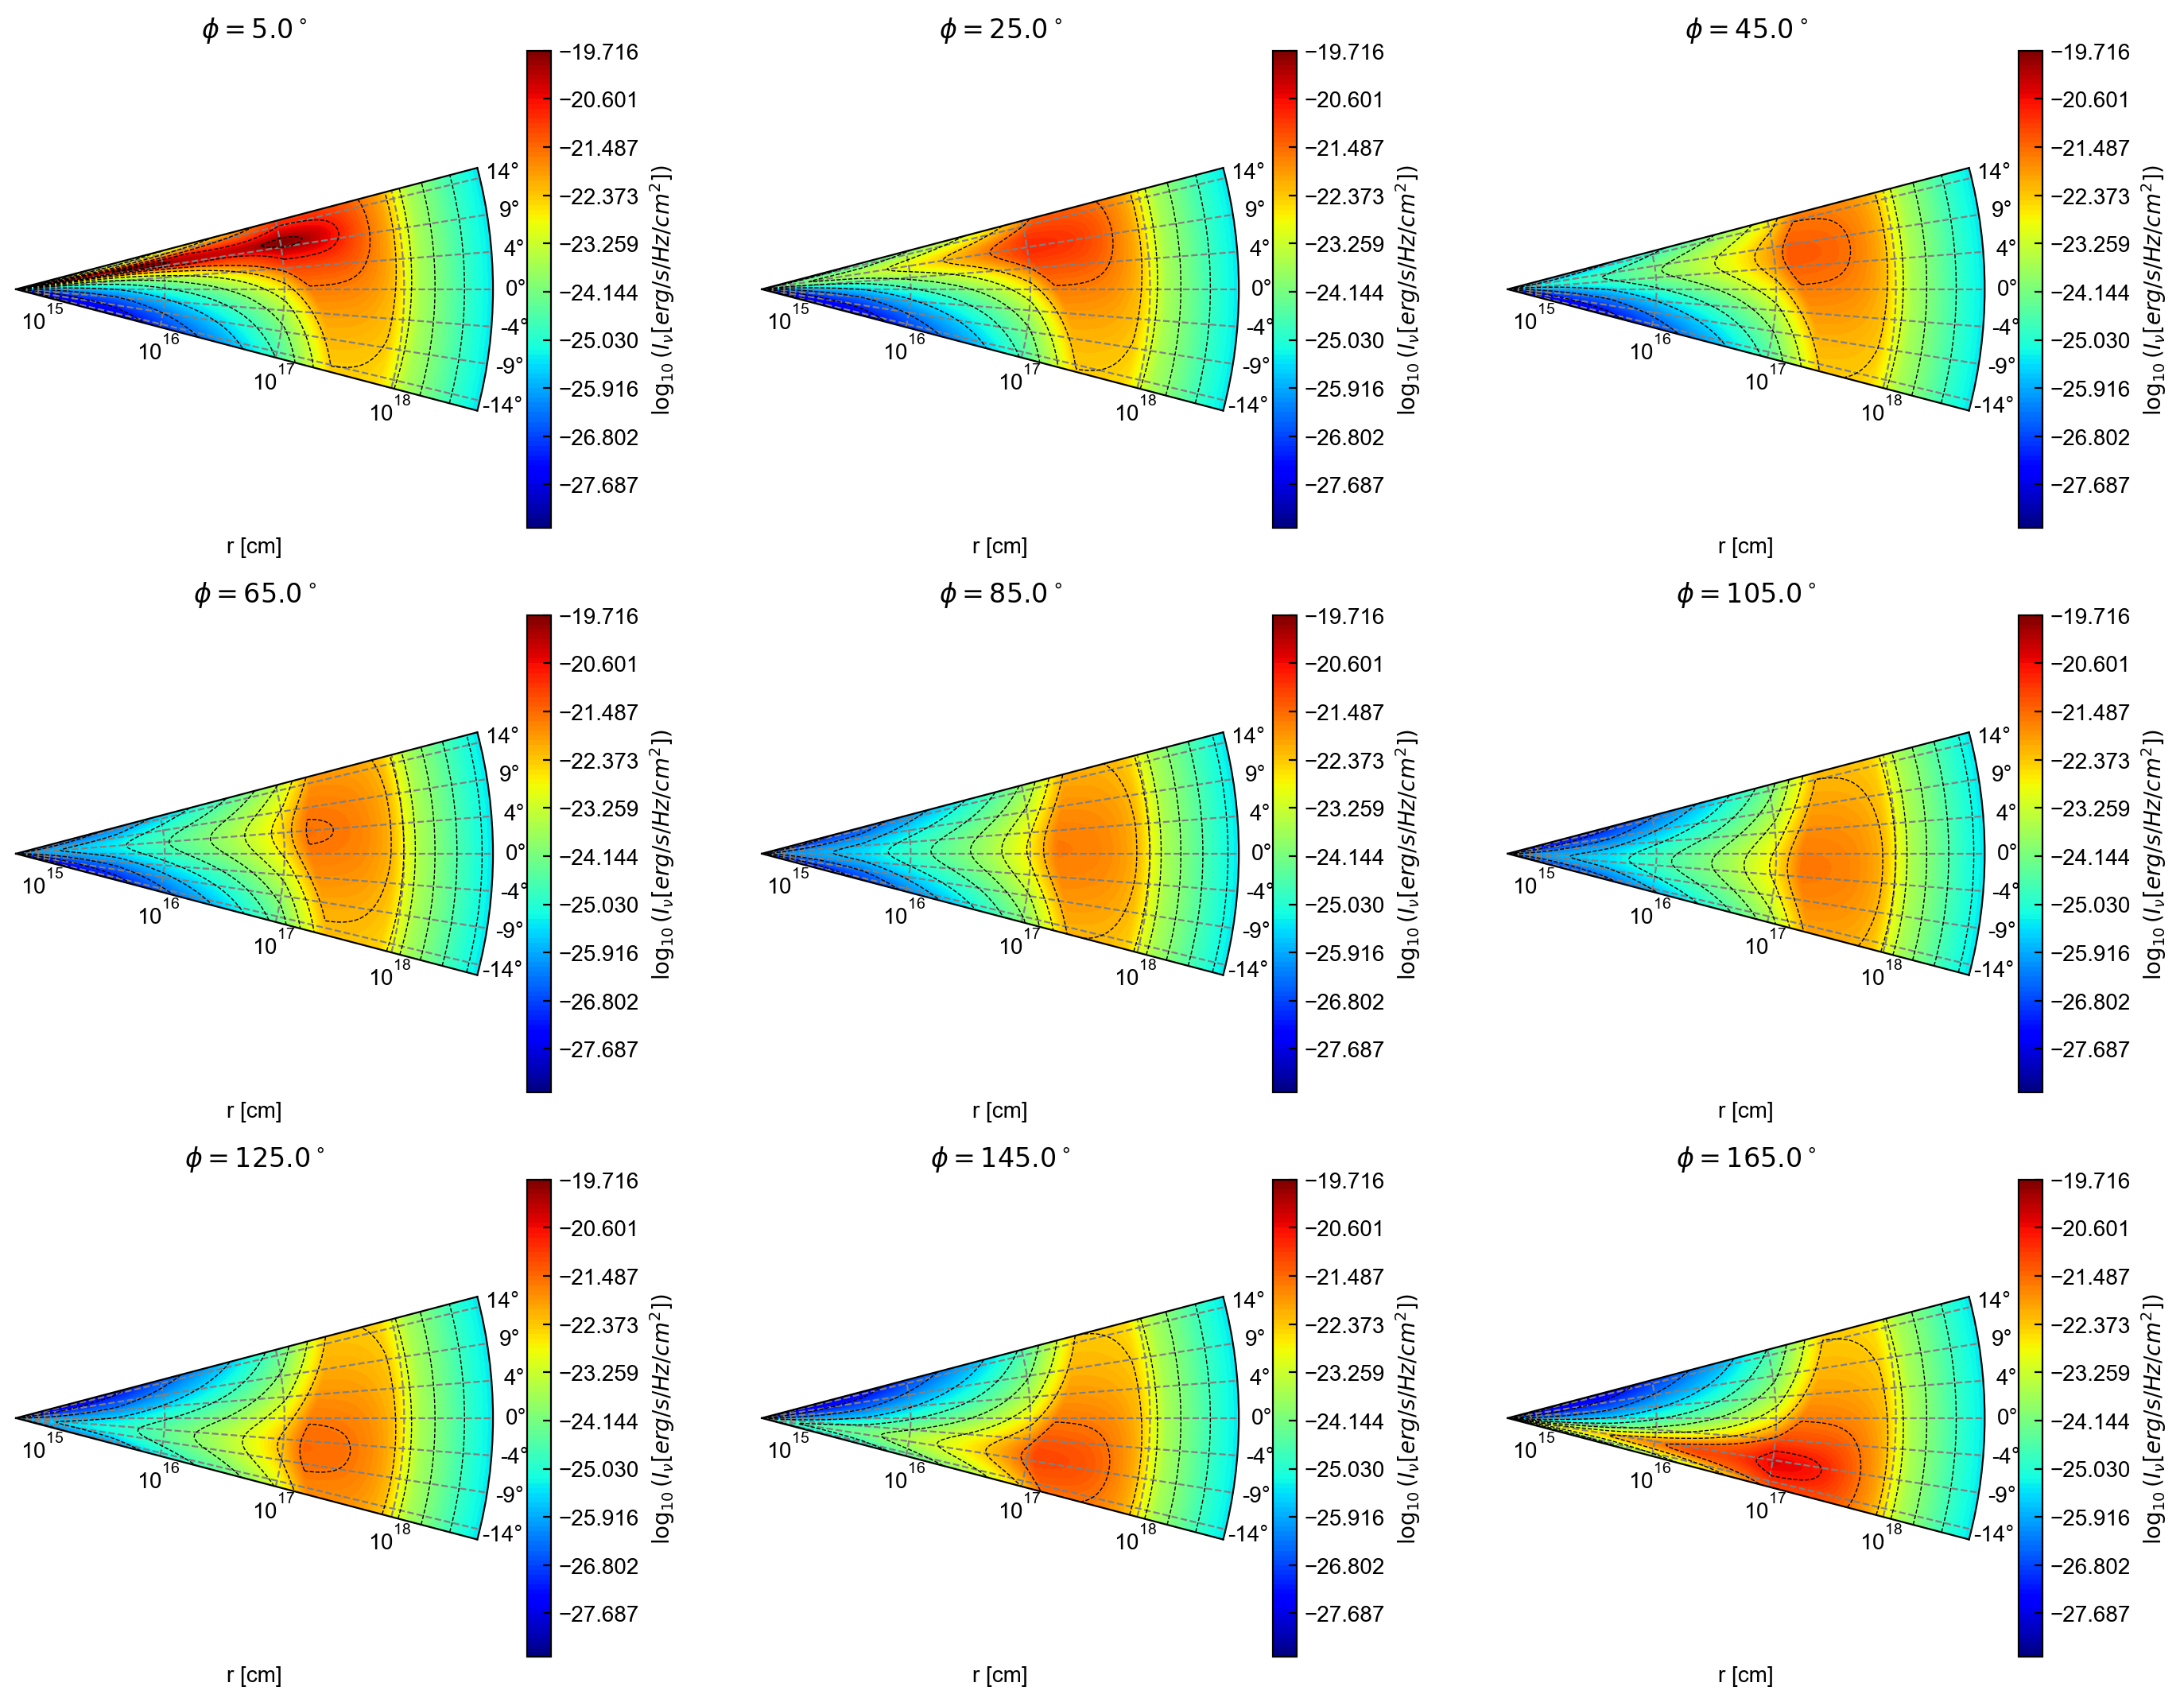

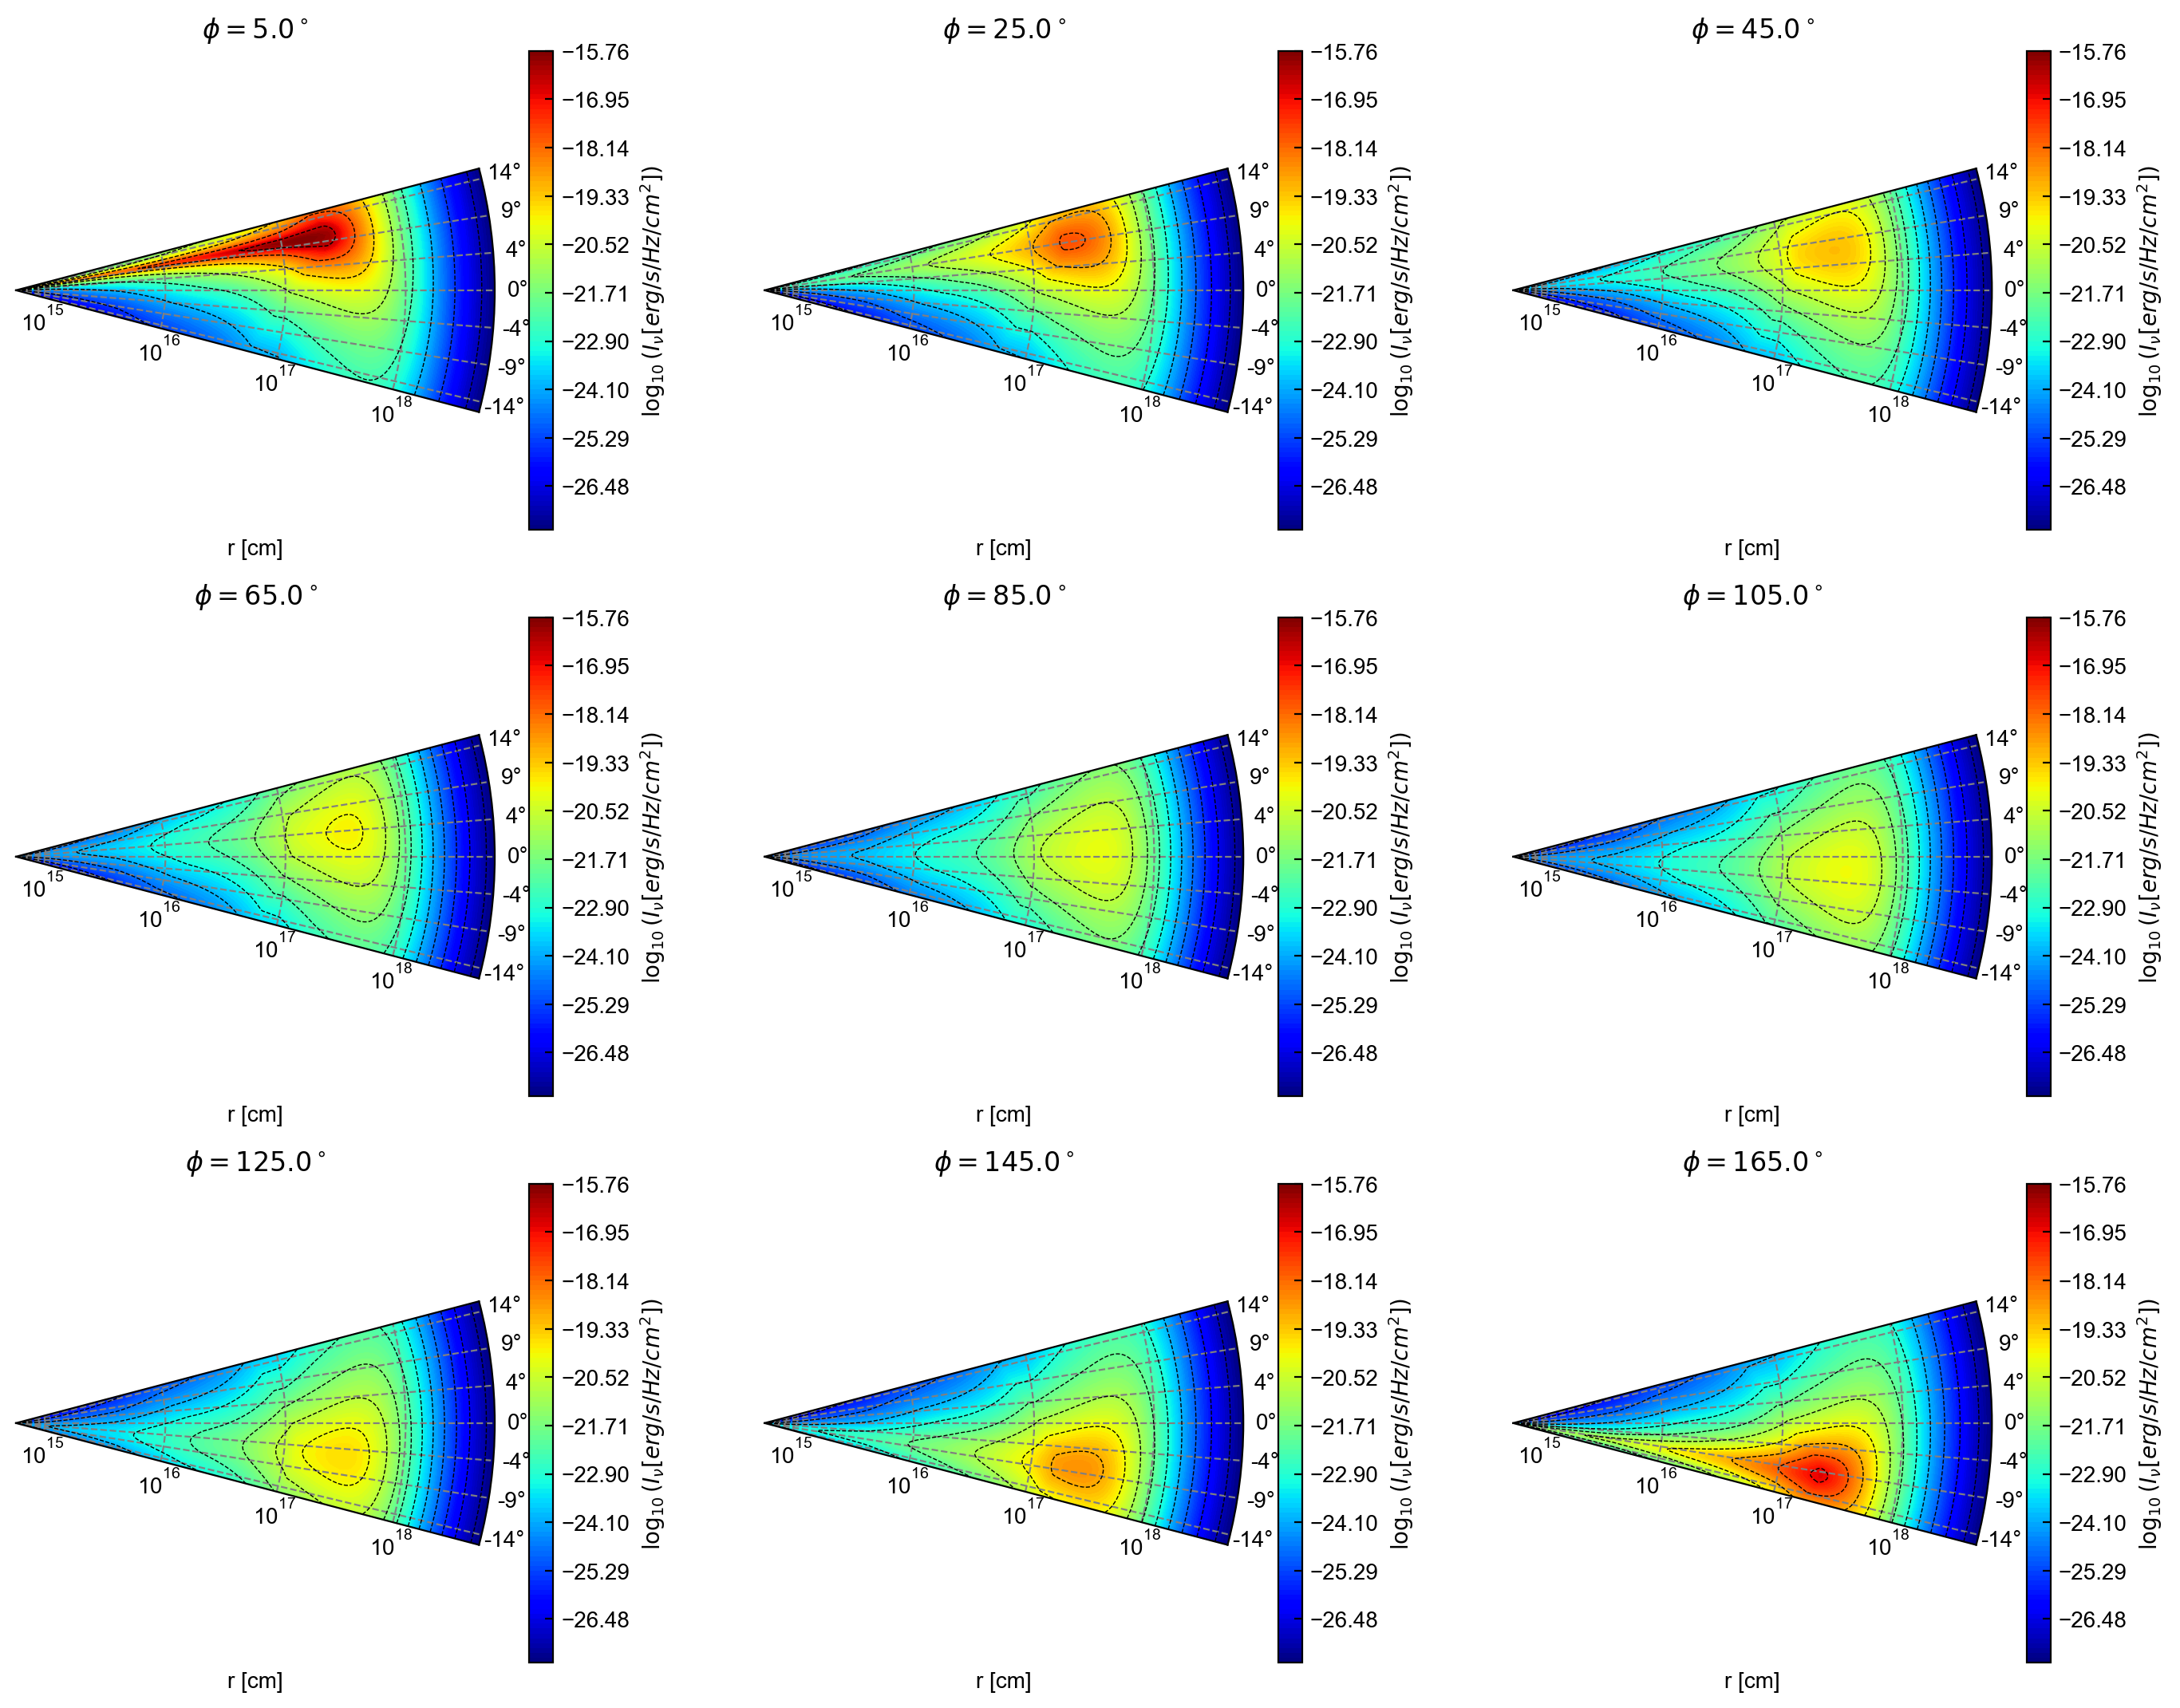

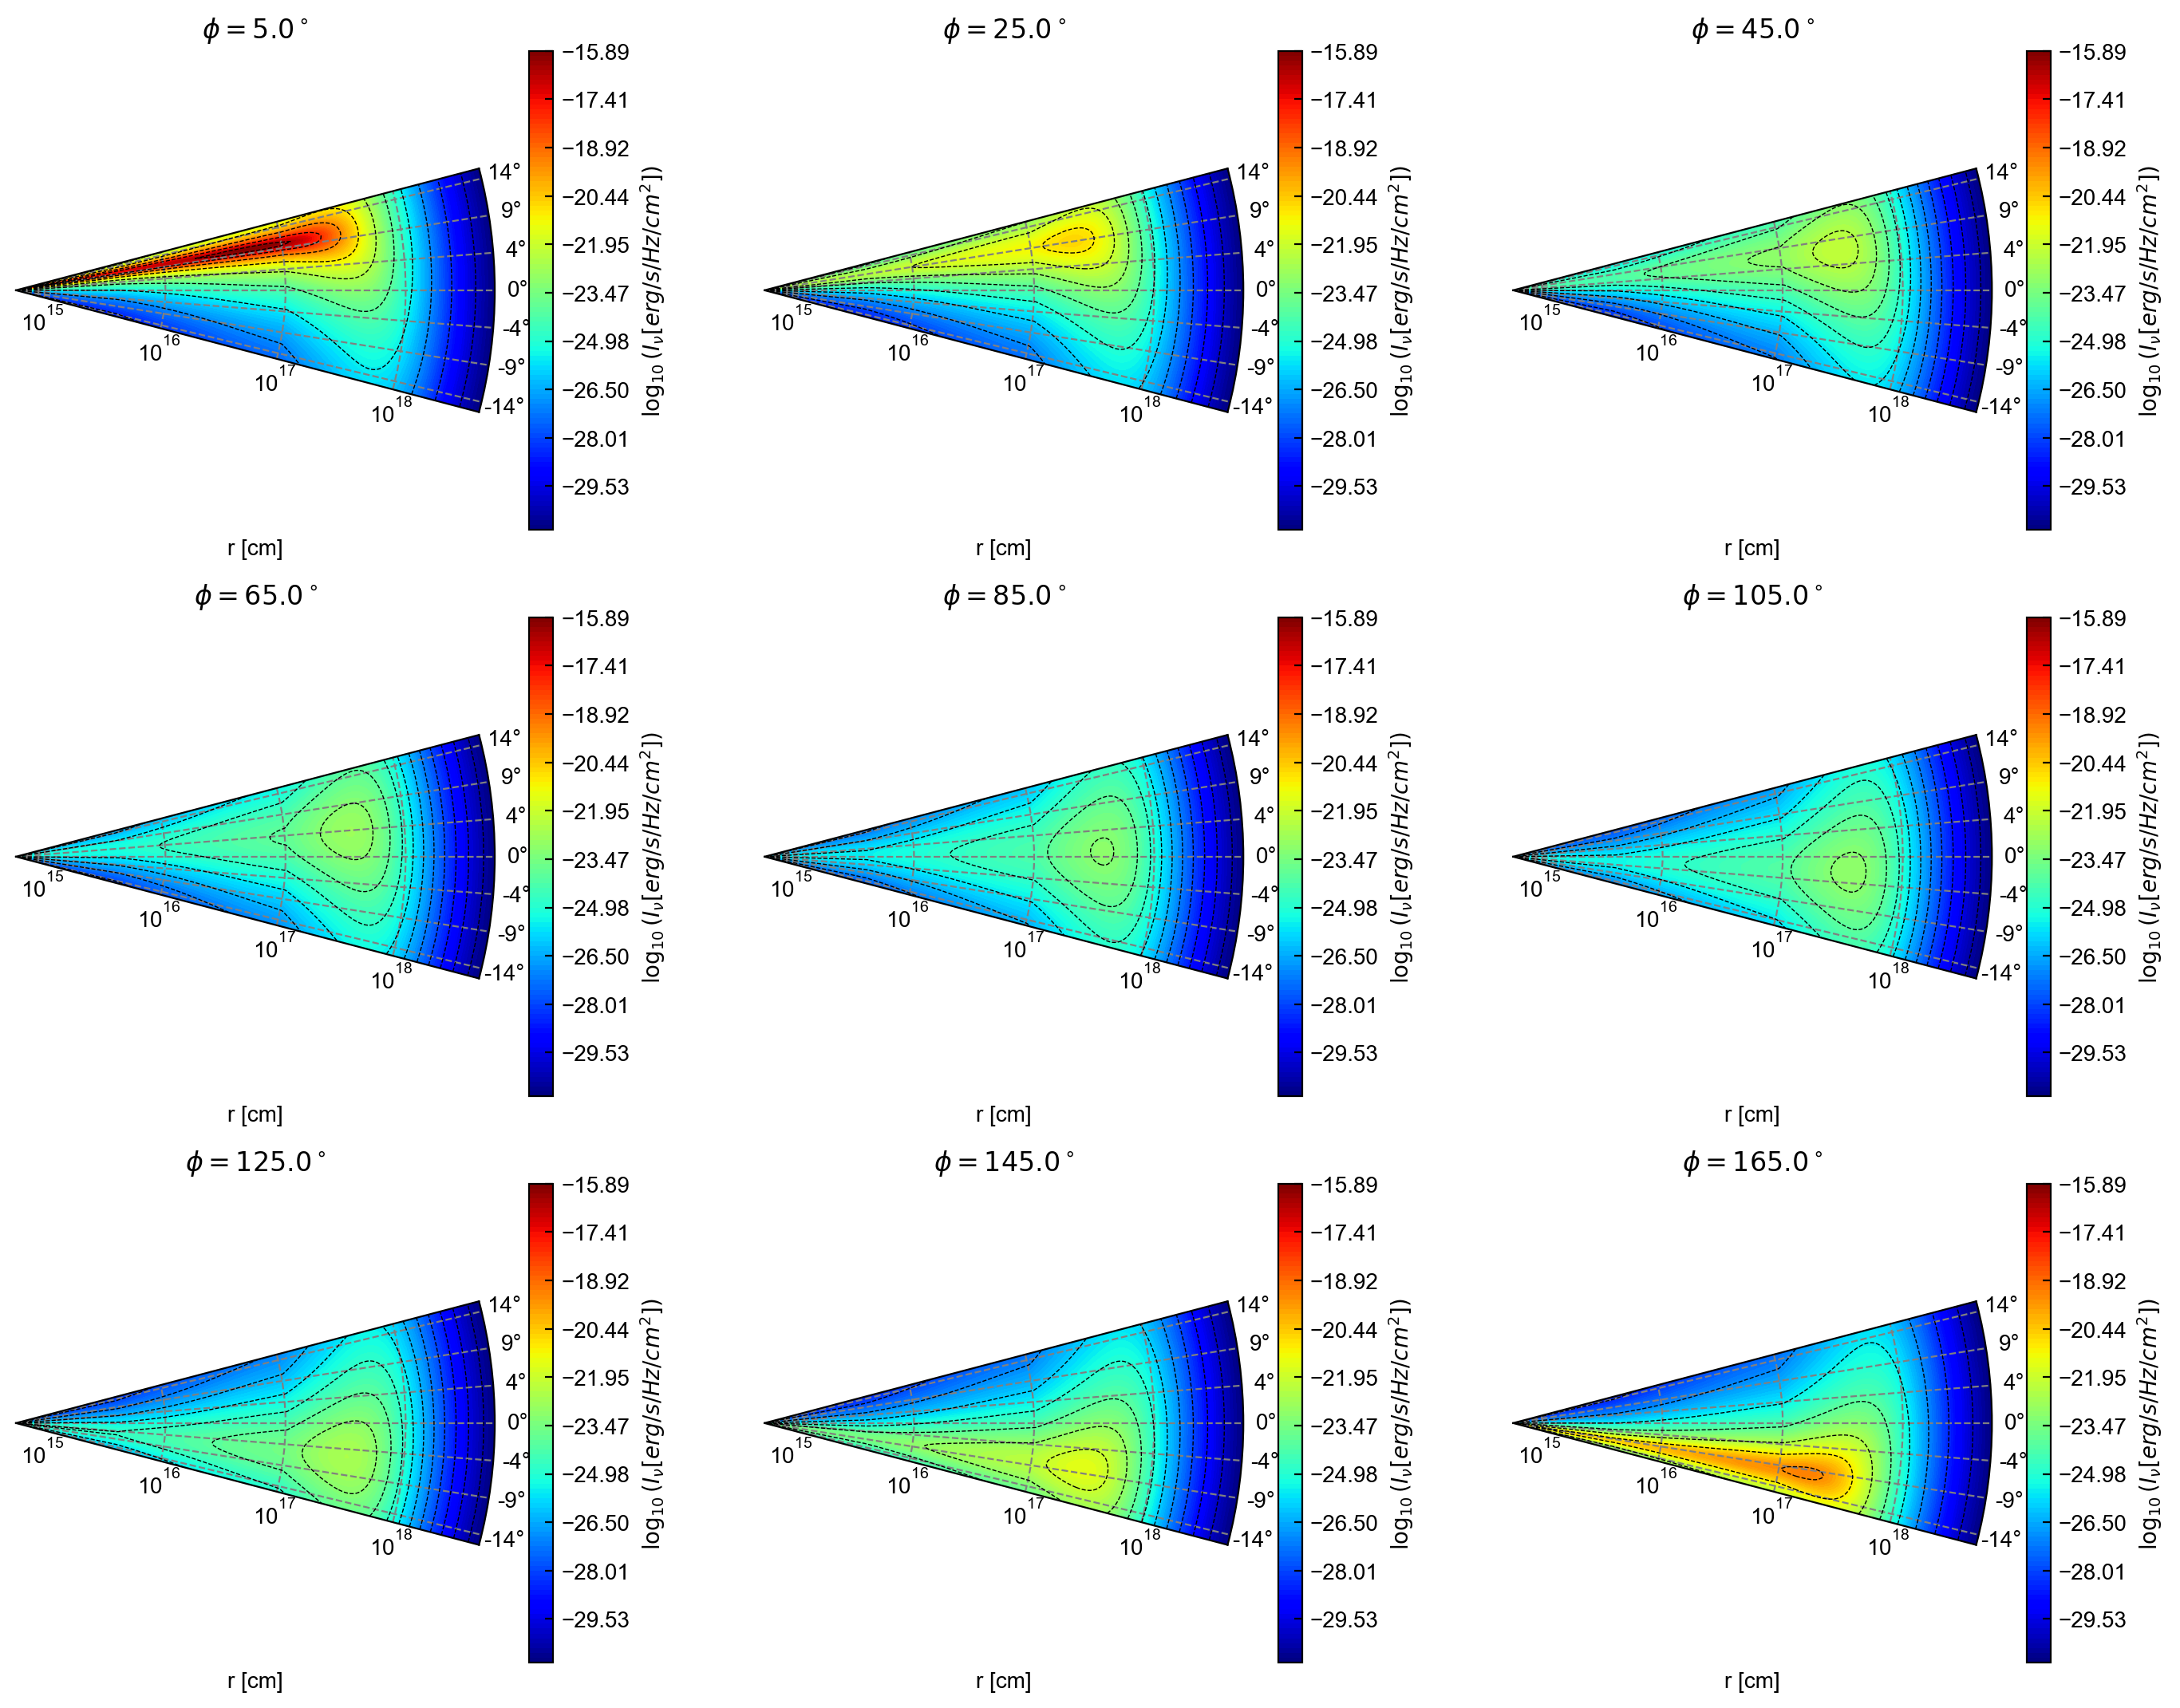

In [11]:
def draw_intensity(r_name, theta_name, phi_name, var_name):
    r1d = np.loadtxt(r_name) * 1.5e13
    theta1d = np.loadtxt(theta_name)
    phi1d = np.loadtxt(phi_name)

    d = np.loadtxt(var_name+'.txt')*2e33*(1.5e13/500)**2/500/(1.5e13)**3

    theta_ext = np.hstack([-theta1d[::-1], theta1d])

    fig = plt.figure(figsize=(4.8*3, 3.6*3))

    axs = [fig.add_subplot(3, 3, i+1,projection='polar') for i in range(int(len(phi1d)/4))]
    
    for i, ax in zip(range(int(len(phi1d)/4)), axs):
        i = i*2
        j = i + int(len(phi1d)/2)
       
        var1 = d[(j*len(theta1d)):(j+1)*len(theta1d),:]
        var2 = d[(i*len(theta1d)):(i+1)*len(theta1d),:]

        r, theta = np.meshgrid(r1d, theta_ext)

        var1 =np.flip(var1, axis=0)
        var = np.vstack([var1, var2])

        cs = ax.contourf(theta, r, np.log10(var), levels = np.linspace(np.log10(d[d>0]).min(),np.log10(d.max()),100), cmap = 'jet')
        cl = ax.contour(theta, r, np.log10(var), levels = 10, colors = 'black', linewidths = 0.5)

        ax.set_title('$\\phi = {:.1f}^\\circ$'.format(phi1d[i]/np.pi*180))
        ax.set_xlim(-theta1d[-1], theta1d[-1])
        ax.set_xlabel('r [cm]')
        cbar = plt.colorbar(cs)
        cbar.set_label('$\\log_{10}(I_\\nu [erg/s/Hz/cm^2])$')
        ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig(var_name+'.png', dpi=300, bbox_inches='tight')
    
draw_intensity(prefix+'r.txt', prefix+'theta.txt', prefix+'phi.txt', prefix+'I_nu_9')
draw_intensity(prefix+'r.txt', prefix+'theta.txt', prefix+'phi.txt', prefix+'I_nu_14')
draw_intensity(prefix+'r.txt', prefix+'theta.txt', prefix+'phi.txt', prefix+'I_nu_17')

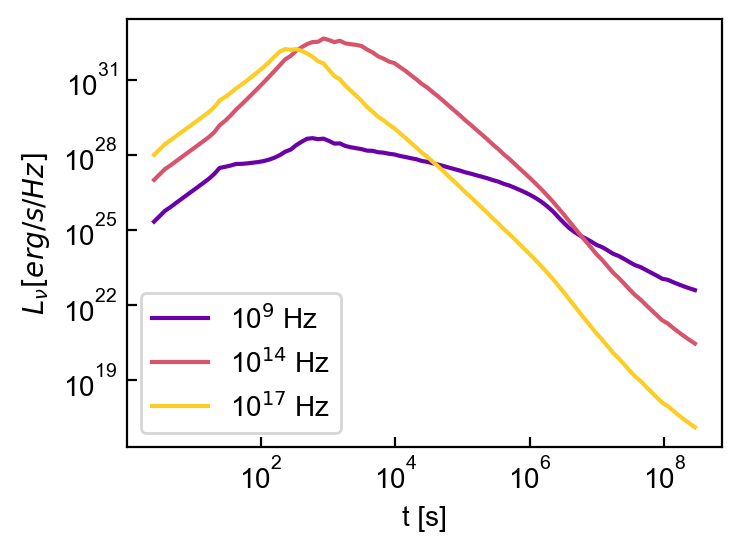

In [15]:
def calc_LC(t_name,L_names):
    

    colors = cm.plasma(np.linspace(0.2, 0.9, len(L_names)))

    fig = plt.figure(figsize=(4.8*0.8, 3.6*0.8))
    ax = fig.add_subplot(1,1,1)

    for L_name ,c in zip(L_names, colors):
        d = np.loadtxt(prefix+L_name)
        t = d[0,:]*500
        Lnu = d[1,:]*2e33*(1.5e13/500)**2

        plt.plot(t, Lnu,c=c,label = '10$^{'+L_name.split('_')[2].split('.')[0] + '}$ Hz')

    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel('t [s]')
    plt.ylabel('$L_{\\nu} [erg/s/Hz]$')
    plt.tight_layout()
    plt.legend()
    plt.savefig('LC.png', dpi=300, bbox_inches='tight')

calc_LC('t_lc.txt', ['L_nu_9.txt', 'L_nu_14.txt', 'L_nu_17.txt'])